# Self-Driving Car Engineer


## Project: **Finding Lane Lines on the Road** 


## Import Packages

In [81]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
from scipy import stats
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


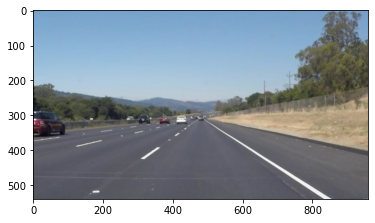

In [82]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)
plt.show()

## Test Images

In [28]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

In [29]:
pictures = os.listdir("test_images/")

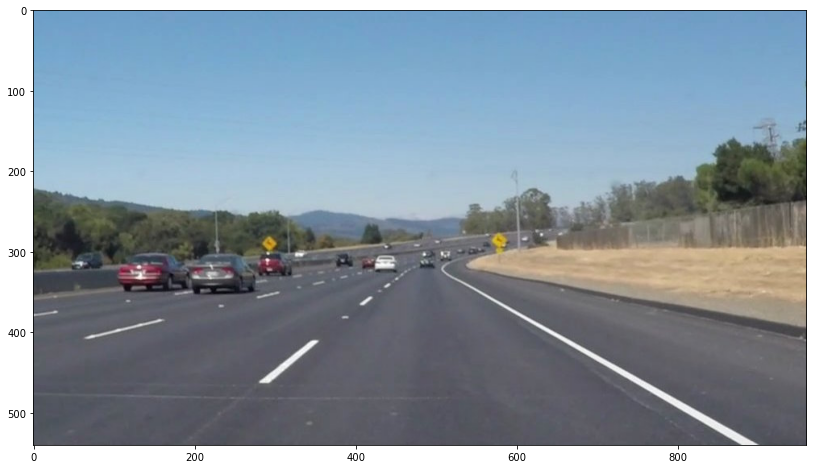

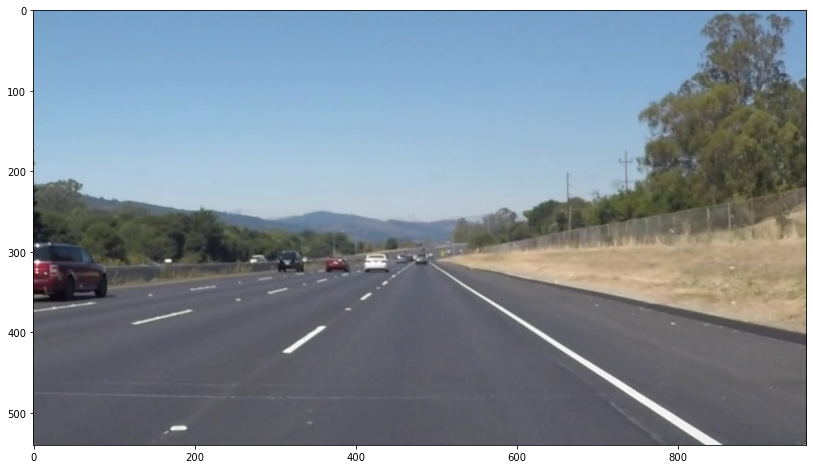

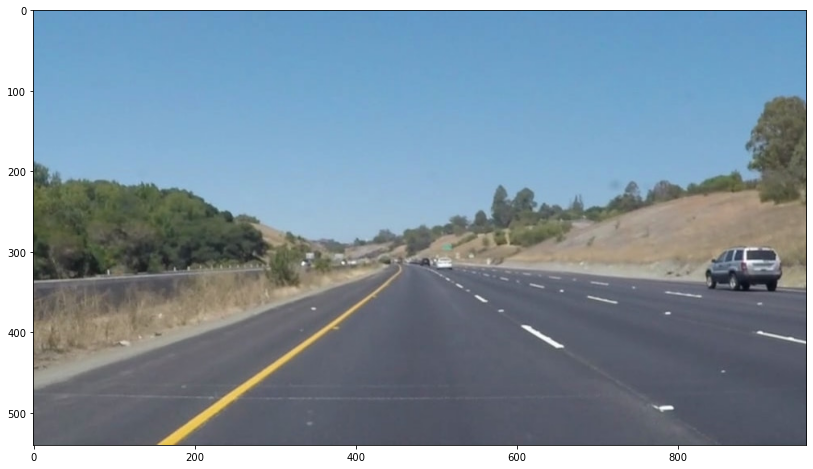

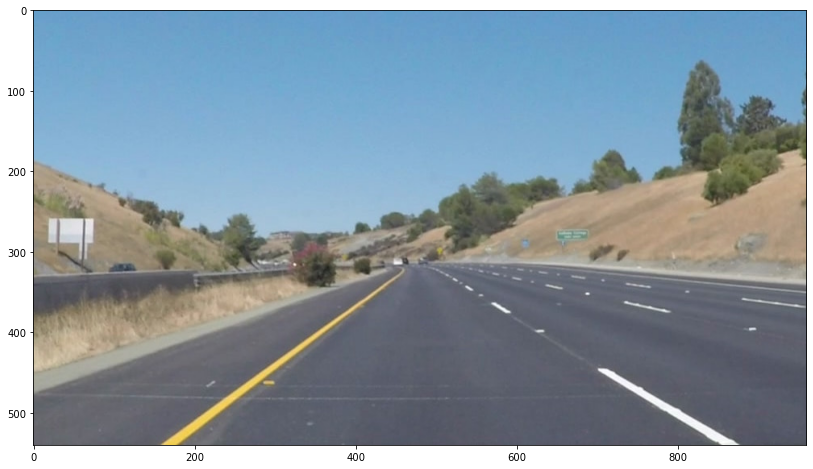

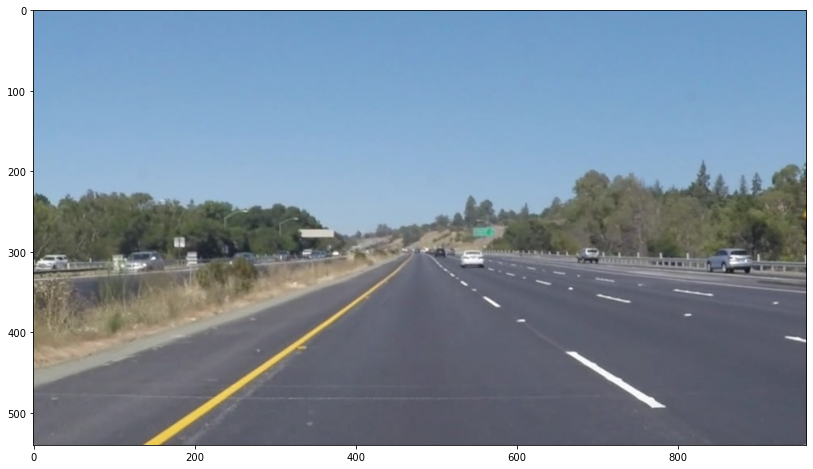

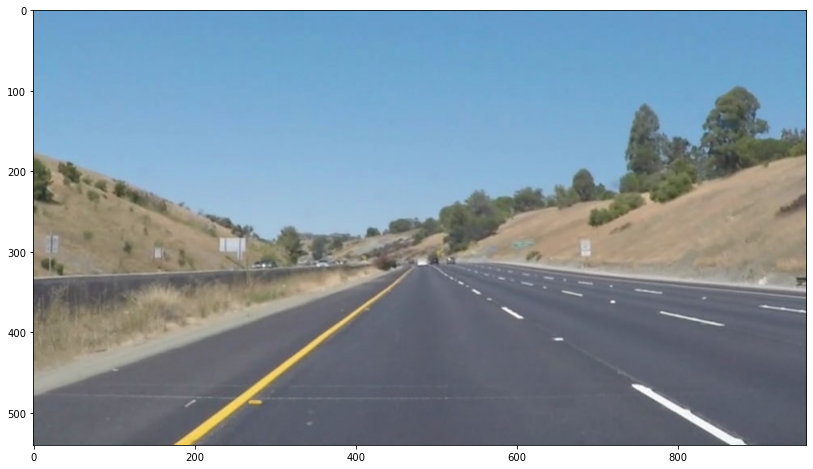

In [80]:
for pic in pictures:
    image = mpimg.imread('test_images/'+pic)
    plt.figure(figsize=(16,8))
    plt.imshow(image)
    plt.show()

## Build a Lane Finding Pipeline



In [83]:
def lane_detector(image):

    # Read in and grayscale the image
    gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)

    # Define a kernel size and apply Gaussian smoothing
    kernel_size = 5
    blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)

    # Define our parameters for Canny and apply
    low_threshold = 50
    high_threshold = 150
    edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

    # Next we'll create a masked edges image using cv2.fillPoly()
    mask = np.zeros_like(edges)   
    ignore_mask_color = 255   

    # This time we are defining a four sided polygon to mask
    imshape = image.shape
    vertices = np.array([[(130,imshape[0]),(450, 320), (520, 320), (920,imshape[0])]], dtype=np.int32)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_edges = cv2.bitwise_and(edges, mask)

    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 2     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 10 #minimum number of pixels making up a line
    max_line_gap = 2    # maximum gap in pixels between connectable line segments
    line_image = np.copy(image)*0 # creating a blank to draw lines on

    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                                min_line_length, max_line_gap)
                
    x_left = []
    y_left = []
    x_right = []
    y_right = []
            
    for line in lines:
        for x1,y1,x2,y2 in line:
            
            slope = float(((y2-y1)/(x2-x1)))
            if ((slope > 0.4) & (slope < 1)): # if the line slope is greater than tan(26.52 deg), it is the right line
                    x_right.append(x1)
                    x_right.append(x2)
                    y_right.append(y1)
                    y_right.append(y2)
            if ((slope < -0.4)&(slope > -1)): # if the line slope is less than tan(153.48 deg), it is the left line
                    x_left.append(x1)
                    x_left.append(x2)
                    y_left.append(y1)
                    y_left.append(y2)
                    
    # extrapolate found x, y 
    if ( (x_left != []) & (y_left != []) & (x_right != []) & (y_right != []) ) :
        slope_left, intercept_left, r_value_left, p_value_left, std_err_left = stats.linregress(x_left, y_left)
        slope_right, intercept_right, r_value_right, p_value_right, std_err_right = stats.linregress(x_right, y_right)
        #print("slope: %f    intercept: %f" % (slope_left, intercept_left))
        #print("slope: %f    intercept: %f" % (slope_right, intercept_right))

        #Find coordinates to draw lines
        #left line
        x_small_left=150
        x_big_left=450

        y_small_left = int(slope_left*x_small_left + intercept_left)
        y_big_left = int(slope_left*x_big_left + intercept_left)

        #right line
        x_small_right=900
        x_big_right=520

        y_small_right = int(slope_right*x_small_right + intercept_right)
        y_big_right = int(slope_right*x_big_right + intercept_right)

        #Draw two lines
        cv2.line(line_image,(x_small_left,y_small_left),(x_big_left,y_big_left),(255,0,0),10)
        cv2.line(line_image,(x_small_right,y_small_right),(x_big_right,y_big_right),(255,0,0),10)

    # Create a "color" binary image to combine with line image
    color_edges = np.dstack((edges, edges, edges)) 

    # Draw the lines on the edge image
    lines_edges = cv2.addWeighted(image, 0.8, line_image, 1, 0)
    return lines_edges

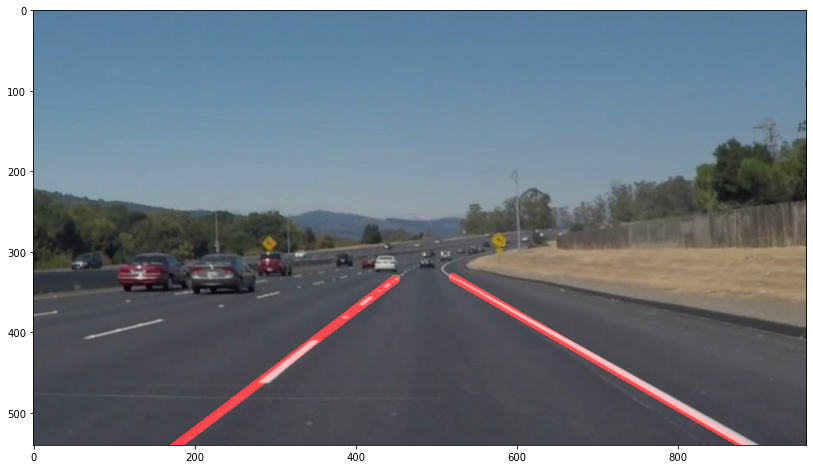

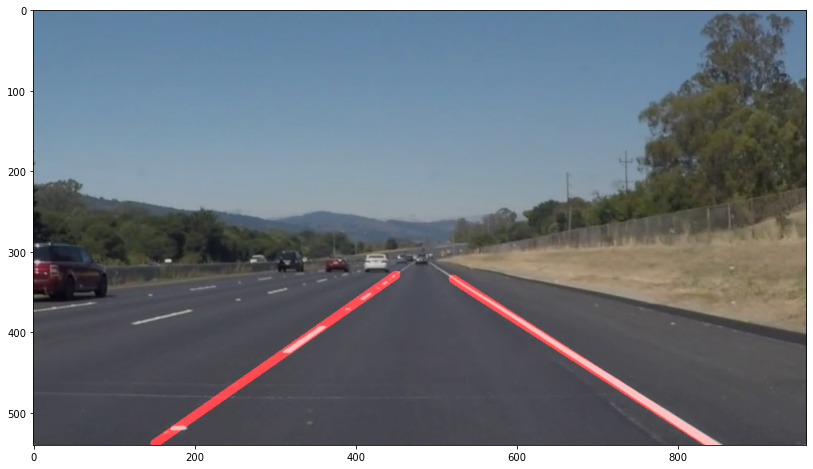

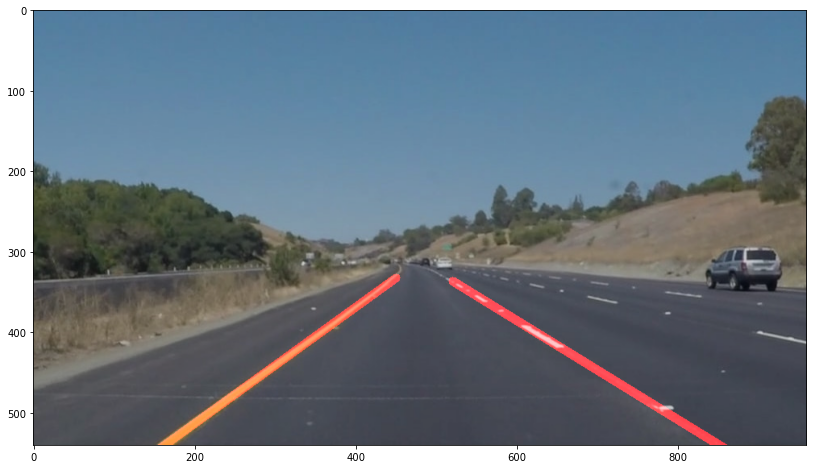

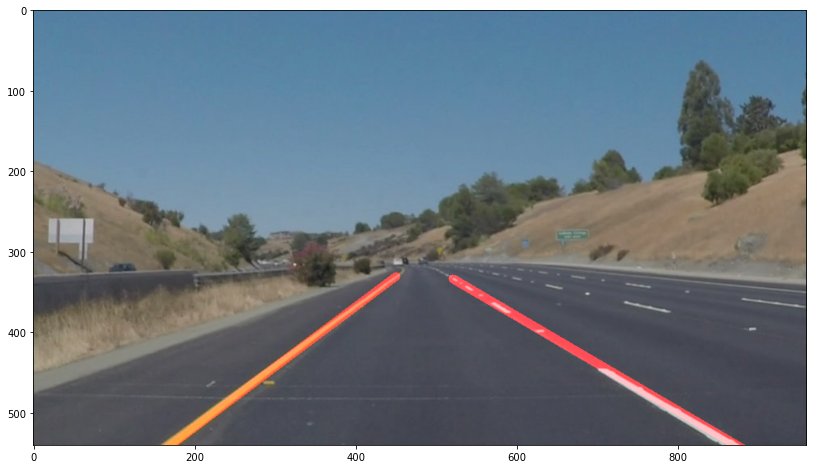

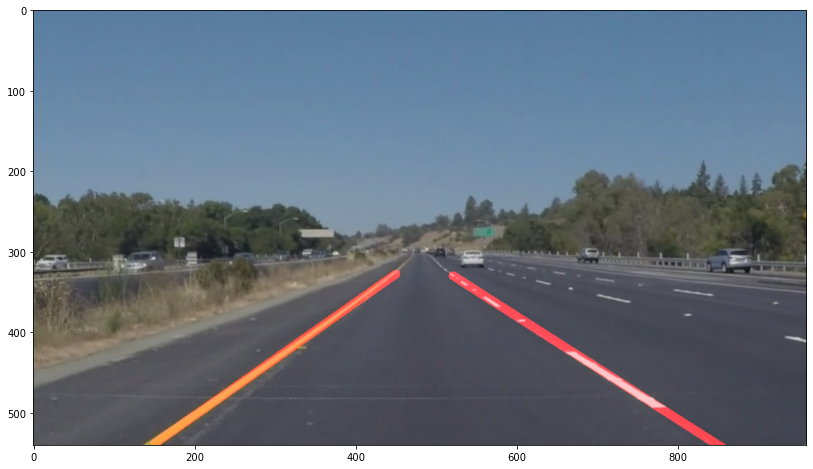

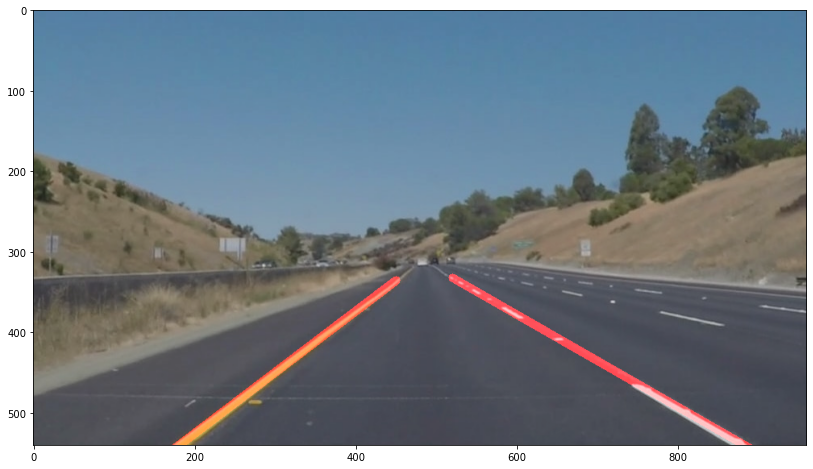

In [84]:
for pic in pictures:
    image = mpimg.imread('test_images/'+pic)
    plt.figure(figsize=(16,8))
    plt.imshow(lane_detector(image))

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [35]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [36]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    result = lane_detector(image)
    
    return result

Let's try the one with the solid white lane on the right first ...

In [88]:
white_output = r'test_videos_output\solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip(r'test_videos\solidWhiteRight.mp4')
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

t:   3%|█▊                                                                   | 6/221 [00:00<00:03, 55.51it/s, now=None]

Moviepy - Building video test_videos_output\solidWhiteRight.mp4.
Moviepy - Writing video test_videos_output\solidWhiteRight.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output\solidWhiteRight.mp4
Wall time: 5.16 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [89]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [90]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

t:   1%|▌                                                                    | 6/681 [00:00<00:12, 53.61it/s, now=None]

Moviepy - Building video test_videos_output/solidYellowLeft.mp4.
Moviepy - Writing video test_videos_output/solidYellowLeft.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidYellowLeft.mp4
Wall time: 16.1 s


In [91]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))